#**Практическое задание №1**

Установка необходимых пакетов:

In [2]:
!pip install -q libtiff
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

     |████████████████████████████████| 129 kB 7.5 MB/s 


Монтирование Вашего Google Drive к текущему окружению:

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
base_dir ='drive/MyDrive/'

Mounted at /content/drive


В переменную PROJECT_DIR необходимо прописать путь к директории на Google Drive, в которую Вы загрузили zip архивы с предоставленными наборами данных.

In [4]:
# todo
#PROJECT_DIR='./'
PROJECT_DIR = 'dev/prak_nn_1/'

Константы, которые пригодятся в коде далее:

In [5]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = False
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')

In [6]:
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [7]:
!pip install libtiff

In [8]:
from pathlib import Path
from libtiff import TIFF
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score

---
### Класс Dataset

Предназначен для работы с наборами данных, хранящихся на Google Drive, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [9]:
import gdown
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        if not Path(f'{name}.npz').exists():
            url = f'https://drive.google.com/uc?id={DATASETS_LINKS[name]}'
            output = f'{name}.npz'
            gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, start=0, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(start, start + self.n_files if not n else start + n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]
  
    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Downloading...
From: https://drive.google.com/uc?id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:00<00:00, 193MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 6.
Label code corresponds to NORM class.


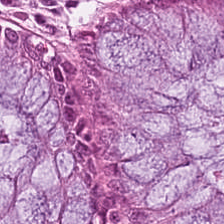

In [10]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [11]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        print([f'{i[0]} : {i[1]}' for i in list(zip(gt, pred))[:5]])
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [14]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.regularizers import l2
import cv2
import os
from random import random, randint
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
%load_ext tensorboard

class Model:

    def __init__(self):
        # Using architecture from https://openaccess.thecvf.com/content_cvpr_2016/papers/Hou_Patch-Based_Convolutional_Neural_CVPR_2016_paper.pdf
        
        self.input_shape=(224, 224, 3)

        self.preproc_batch = self.preproc_batch_default
        self.model = tf.keras.Sequential([
          tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=1, input_shape=self.input_shape, kernel_regularizer=l2(.0003)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.ReLU(),
          tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=3),

          tf.keras.layers.Conv2D(filters=128, kernel_size=5, kernel_regularizer=l2(.0003)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.ReLU(),
          tf.keras.layers.MaxPool2D(pool_size=3, strides=2),

          tf.keras.layers.Conv2D(filters=256, kernel_size=3, kernel_regularizer=l2(.0003)),
          tf.keras.layers.ReLU(),

          tf.keras.layers.Conv2D(filters=256, kernel_size=3, kernel_regularizer=l2(.0003)),
          tf.keras.layers.ReLU(),
          tf.keras.layers.MaxPool2D(pool_size=3, strides=1),

          tf.keras.layers.Conv2D(filters=512, kernel_size=3, kernel_regularizer=l2(.0003)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.ReLU(),

          tf.keras.layers.Conv2D(filters=512, kernel_size=3, kernel_regularizer=l2(.0003)),
          tf.keras.layers.ReLU(),

          tf.keras.layers.Conv2D(filters=1024, kernel_size=3, kernel_regularizer=l2(.0003)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.ReLU(),

          tf.keras.layers.Conv2D(filters=1024, kernel_size=3, kernel_regularizer=l2(.0003)),
          tf.keras.layers.ReLU(),

          tf.keras.layers.GlobalAveragePooling2D(),

          tf.keras.layers.Dense(units=1024, activation='relu'),
          tf.keras.layers.Dropout(rate=0.5),

          tf.keras.layers.Dense(units=1024, activation='relu'),
          tf.keras.layers.Dropout(rate=0.5),

          tf.keras.layers.Dense(units=9, activation='softmax')
        ])

        self.save_path=base_dir + PROJECT_DIR + 'best.h5'
        self.checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=self.save_path,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=True
        )

        self.model.compile(optimizer='adam',
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                           metrics=['accuracy'])
        
        self.logdir = base_dir + PROJECT_DIR + 'logs'
        self.tensorboard_callback = tf.keras.callbacks.TensorBoard(self.logdir, histogram_freq=1)

    def summary(self):
      print(self.model.summary())

    def save(self, name: str):
        # Unnecessary, the callback saves the best model instance during training
        pass

    @staticmethod
    def load(name: str):
        model = Model()
        if os.path.exists(base_dir + PROJECT_DIR + f'{name}.h5'):
          model.model = tf.keras.models.load_model(base_dir + PROJECT_DIR + f'{name}.h5')

        if 'best_densenet' in name:
          print('Changing preprocessor')
          model.preproc_batch = model.preproc_batch_densenset
        elif 'best_resnet' in name:
          print('Changing preprocessor')
          model.preproc_batch = model.preproc_batch_resnet
        else:
          model.preproc_batch = model.preproc_batch_default

        return model

    def train(self, train_ds):
        print(f'training started')
        
        for i in range(10):

          n = 500
          x_train, y_train = train_ds.random_batch_with_labels(n)
          x_train = self.preproc_batch(x_train)

          x_val, y_val = train_ds.random_batch_with_labels(150)
          x_val = self.preproc_batch(x_val, 0)

          print(x_train.shape, y_train.shape)
          self.model.fit(x_train, y_train, epochs=40, callbacks=[self.checkpoint_callback], validation_data=(x_val, y_val))

        print(f'training done')
        pass

    def preproc_batch_default(self, batch, thr=.5):
      imgs = []
      for image in batch:
        if random() < thr:
          border = randint(10, 40)
          image = image[border:-border, border:-border]
        img = cv2.resize(image/255., self.input_shape[:2], interpolation=cv2.INTER_CUBIC)
        if random() < thr:
          img = img[:, ::-1]
        if random() < thr:
          img = img[::-1]
        img -= np.mean(img)
        img /= (np.std(img) + 0.00001)
        imgs.append(img)

      return np.stack(imgs)

    def preproc_batch_densenset(self, batch, thr=None):
      imgs = []
      for image in batch:
        imgs.append(tf.keras.applications.densenet.preprocess_input(image.astype(np.float)))

      return np.stack(imgs)

    def preproc_batch_resnet(self, batch, thr=None):
      imgs = []
      for image in batch:
        imgs.append(tf.keras.applications.resnet_v2.preprocess_input(image.astype(np.float)))

      return np.stack(imgs)

    def preproc_batch_deprecated(self, batch, thr=.5):
      imgs = []
      for image in batch:
        if random() < thr:
          border = randint(10, 40)
          image = image[border:-border, border:-border]
        img = cv2.resize(image/255., self.input_shape[:2], interpolation=cv2.INTER_CUBIC)
        if random() < thr:
          img = img[:, ::-1]
        if random() < thr:
          img = img[::-1]
        imgs.append(img)

      return np.stack(imgs)

    def test_on_dataset(self, dataset: Dataset, limit=None):
        # you can upgrade this code if you want to speed up testing using batches
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        batch_size = 100
        current = 0
        for current in tqdm(range(0, n, min(batch_size, n - current))):
          for img in self.preproc_batch(dataset.images_seq(current, min(batch_size, n - current)), 0):
            predictions.append(self.test_on_image(img[np.newaxis, :]))
        return predictions

    def test_on_image(self, img: np.ndarray):
      prediction = self.model.predict(img)
      return np.argmax(prediction)

    @staticmethod
    def stacked_test(test_ds, models):

      preds_clean = np.zeros((len(models), test_ds.n_files), dtype=np.int8)
      for i, name in enumerate(models):
        model = Model.load(name)
        preds_clean[i] = model.test_on_dataset(test_ds, limit=1.)
        print(f'Model {name} evaluated')

      preds = preds_clean.T

      preds_stacked = np.zeros(len(preds), dtype=np.int8)
      for i, p in enumerate(preds):
        preds_stacked[i] = np.argmax(np.bincount(p))

      return preds_stacked


2.8.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [13]:
d_train = Dataset('train_small')
d_test = Dataset('test_small')

Downloading...
From: https://drive.google.com/uc?id=1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR
To: /content/train_small.npz
100%|██████████| 841M/841M [00:06<00:00, 126MB/s]


Loading dataset train_small from npz.
Done. Dataset train_small consists of 7200 images.


Downloading...
From: https://drive.google.com/uc?id=1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI
To: /content/test_small.npz
100%|██████████| 211M/211M [00:01<00:00, 132MB/s]


Loading dataset test_small from npz.
Done. Dataset test_small consists of 1800 images.


In [17]:
model = Model()
if not EVALUATE_ONLY:
    model.train(d_train)
    model.save('best')
else:
    model = Model.load('best.h5')

Пример тестирования модели на части набора данных:

In [ ]:
model.train(d_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
Epoch 17: val_accuracy did not improve from 0.85333
16/16 [==============================] - 5s 291ms/step - loss: 0.3609 - accuracy: 0.9520 - val_loss: 1.2915 - val_accuracy: 0.7600
Epoch 18/40
16/16 [==============================] - ETA: 0s - loss: 0.3715 - accuracy: 0.9540
Epoch 18: val_accuracy did not improve from 0.85333
16/16 [==============================] - 5s 295ms/step - loss: 0.3715 - accuracy: 0.9540 - val_loss: 0.9317 - val_accuracy: 0.8267
Epoch 19/40
16/16 [==============================] - ETA: 0s - loss: 0.3697 - accuracy: 0.9540
Epoch 19: val_accuracy did not improve from 0.85333
16/16 [==============================] - 5s 292ms/step - loss: 0.3697 - accuracy: 0.9540 - val_loss: 1.0143 - val_accuracy: 0.8000
Epoch 20/40
16/16 [==============================] - ETA: 0s - loss: 0.3818 - accuracy: 0.9500
Epoch 20: val_accuracy did not improve from 0.85333
16/16 [==============================] - 5s 29

In [ ]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '100% of test')


metrics for 100.0% of test:
['0 : 0', '0 : 0', '0 : 0', '0 : 0', '0 : 0']
	 accuracy 0.8836:
	 balanced accuracy 0.8836:


Пример тестирования модели на полном наборе данных:

In [ ]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = Model.stacked_test(d_test, ['models/best6', 'models/best_resnet', 'models/best_densenet'])
    Metrics.print_all(d_test.labels, pred_2, 'test')

Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [ ]:
d_test_tiny = Dataset('test', PROJECT_DIR)
pred = Model.stacked_test(d_test_tiny, ['models/best6', 'models/best_resnet', 'models/best_densenet'])
Metrics.print_all(d_test_tiny.labels, pred, 'test')

Loading dataset test from npz.
Done. Dataset test consists of 4500 images.



Model models/best6 evaluated
Changing preprocessor



Model models/best_resnet evaluated
Changing preprocessor



Model models/best_densenet evaluated
metrics for test:
['0 : 0', '0 : 0', '0 : 0', '0 : 0', '0 : 0']
	 accuracy 0.9544:
	 balanced accuracy 0.9544:


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
'''import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')'''

"import timeit\n\ndef factorial(n):\n    res = 1\n    for i in range(1, n + 1):\n        res *= i\n    return res\n\n\ndef f():\n    return factorial(n=1000)\n\nn_runs = 128\nprint(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')"

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
'''# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()'''

'# Standard scientific Python imports\nimport matplotlib.pyplot as plt\n\n# Import datasets, classifiers and performance metrics\nfrom sklearn import datasets, svm, metrics\nfrom sklearn.model_selection import train_test_split\n\n# The digits dataset\ndigits = datasets.load_digits()\n\n# The data that we are interested in is made of 8x8 images of digits, let\'s\n# have a look at the first 4 images, stored in the `images` attribute of the\n# dataset.  If we were working from image files, we could load them using\n# matplotlib.pyplot.imread.  Note that each image must have the same size. For these\n# images, we know which digit they represent: it is given in the \'target\' of\n# the dataset.\n_, axes = plt.subplots(2, 4)\nimages_and_labels = list(zip(digits.images, digits.target))\nfor ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):\n    ax.set_axis_off()\n    ax.imshow(image, cmap=plt.cm.gray_r, interpolation=\'nearest\')\n    ax.set_title(\'Training: %i\' % label)\n\n# To

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
'''import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()'''

"import numpy as np\nimport matplotlib.pyplot as plt\nfrom scipy import ndimage as ndi\n\nfrom skimage import feature\n\n\n# Generate noisy image of a square\nim = np.zeros((128, 128))\nim[32:-32, 32:-32] = 1\n\nim = ndi.rotate(im, 15, mode='constant')\nim = ndi.gaussian_filter(im, 4)\nim += 0.2 * np.random.random(im.shape)\n\n# Compute the Canny filter for two values of sigma\nedges1 = feature.canny(im)\nedges2 = feature.canny(im, sigma=3)\n\n# display results\nfig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),\n                                    sharex=True, sharey=True)\n\nax1.imshow(im, cmap=plt.cm.gray)\nax1.axis('off')\nax1.set_title('noisy image', fontsize=20)\n\nax2.imshow(edges1, cmap=plt.cm.gray)\nax2.axis('off')\nax2.set_title(r'Canny filter, $\\sigma=1$', fontsize=20)\n\nax3.imshow(edges2, cmap=plt.cm.gray)\nax3.axis('off')\nax3.set_title(r'Canny filter, $\\sigma=3$', fontsize=20)\n\nfig.tight_layout()\n\nplt.show()"

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
'''# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)'''

"# Install TensorFlow\n\nimport tensorflow as tf\n\nmnist = tf.keras.datasets.mnist\n\n(x_train, y_train), (x_test, y_test) = mnist.load_data()\nx_train, x_test = x_train / 255.0, x_test / 255.0\n\nmodel = tf.keras.models.Sequential([\n  tf.keras.layers.Flatten(input_shape=(28, 28)),\n  tf.keras.layers.Dense(128, activation='relu'),\n  tf.keras.layers.Dropout(0.2),\n  tf.keras.layers.Dense(10, activation='softmax')\n])\n\nmodel.compile(optimizer='adam',\n              loss='sparse_categorical_crossentropy',\n              metrics=['accuracy'])\n\nmodel.fit(x_train, y_train, epochs=5)\n\nmodel.evaluate(x_test,  y_test, verbose=2)"

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru. 

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb 

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
'''arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"'''

'arr1 = np.random.rand(100, 100, 3) * 255\narr2 = np.random.rand(100, 100, 3) * 255\n\nimg1 = Image.fromarray(arr1.astype(\'uint8\'))\nimg2 = Image.fromarray(arr2.astype(\'uint8\'))\n\np = "/content/drive/MyDrive/" + PROJECT_DIR\n\nif not (Path(p) / \'tmp\').exists():\n    (Path(p) / \'tmp\').mkdir()\n\nimg1.save(str(Path(p) / \'tmp\' / \'img1.png\'))\nimg2.save(str(Path(p) / \'tmp\' / \'img2.png\'))\n\n%cd $p\n!zip -r "tmp.zip" "tmp"'

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
'''p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"'''

'p = "/content/drive/MyDrive/" + PROJECT_DIR\n%cd $p\n!unzip -uq "tmp.zip" -d "tmp2"'